In [52]:
import scipy
import numpy as np
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report as cr
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from joblib import dump

In [31]:
FREQ_DECREASE_RATIO = 1/10

In [3]:
input_data = scipy.io.loadmat('files/acc_data.mat')
output_data = scipy.io.loadmat('files/acc_labels.mat')

In [7]:
print(input_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'acc_data'])


In [12]:
x = input_data['acc_data']
y = output_data['acc_labels'][:, 0]
print(x.shape, y.shape)

(11771, 453) (11771,)


In [20]:
run_jump = (y == 4) | (y == 6)
x = np.delete(x, run_jump, 0)
y = np.delete(y, run_jump)
print(x.shape, y.shape)

(9040, 453) (9040,)


In [21]:
x0 = x[y <= 9]
x1 = x[y > 9]
print(x0.shape, x1.shape)

(4848, 453) (4192, 453)


In [23]:
lower = min(x0.shape[0], x1.shape[0])
print(lower)

x0 = shuffle(x0)
x1 = shuffle(x1)

x0 = x0[:lower]
x1 = x1[:lower]

x = np.concatenate((x0, x1), 0)
y = np.array([0]*lower+[1]*lower).reshape((-1, 1))
print(x.shape, y.shape)

4192
(8384, 453) (8384, 1)


In [25]:
n_smp = x.shape[0]
batch_len = x.shape[1] // 3

for (i, smp) in enumerate(x):
    smp_x = smp[:batch_len]
    smp_y = smp[batch_len:-batch_len]
    smp_z = smp[-batch_len:]
    if i == 0:
        xx = smp_x
        xy = smp_y
        xz = smp_z
    else:
        xx = np.concatenate((xx, smp_x))
        xy = np.concatenate((xy, smp_y))
        xz = np.concatenate((xz, smp_z))
        
print(xx.shape, xy.shape, xz.shape)

(1265984,) (1265984,) (1265984,)


In [27]:
scaler = StandardScaler()

xx = xx.reshape((-1, 1))
xy = xy.reshape((-1, 1))
xz = xz.reshape((-1, 1))

x_series = np.concatenate((xx, xy, xz), 1)

x_nrm = scaler.fit_transform(x_series)

In [35]:
x = []
sampling_step = round(1/FREQ_DECREASE_RATIO)
print(sampling_step)
for i in range(n_smp):
    x.append(np.concatenate((x_nrm[i*batch_len:(i+1)*batch_len, 0][::sampling_step].reshape((-1, 1)),
                    x_nrm[i*batch_len:(i+1)*batch_len, 1][::sampling_step].reshape((-1, 1)),
                    x_nrm[i*batch_len:(i+1)*batch_len, 2][::sampling_step].reshape((-1, 1))), 1))

x = np.array(x)
print(x.shape)

10
(8384, 16, 3)


In [38]:
x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.8, random_state=42)

In [40]:
cb = EarlyStopping(patience=4, restore_best_weights=True)

In [43]:
model = Sequential()

model.add(LSTM(128, input_shape=x_train.shape[1:], return_sequences=True))

model.add(LSTM(64))

model.add(Dense(64))

model.add(Dense(32))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 16, 128)           67584     
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 123,265
Trainable params: 123,265
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
results = model.fit(x_train, y_train, epochs=64, validation_data=(x_val, y_val), callbacks=cb)

Epoch 1/64
210/210 [==============================] - 12s 35ms/step - loss: 0.2679 - accuracy: 0.8760 - val_loss: 0.1344 - val_accuracy: 0.9481
Epoch 2/64
210/210 [==============================] - 7s 32ms/step - loss: 0.1405 - accuracy: 0.9478 - val_loss: 0.0945 - val_accuracy: 0.9600
Epoch 3/64
210/210 [==============================] - 7s 33ms/step - loss: 0.1123 - accuracy: 0.9571 - val_loss: 0.0839 - val_accuracy: 0.9672
Epoch 4/64
210/210 [==============================] - 7s 33ms/step - loss: 0.0925 - accuracy: 0.9645 - val_loss: 0.0590 - val_accuracy: 0.9761
Epoch 5/64
210/210 [==============================] - 7s 33ms/step - loss: 0.0741 - accuracy: 0.9706 - val_loss: 0.1012 - val_accuracy: 0.9648
Epoch 6/64
210/210 [==============================] - 7s 33ms/step - loss: 0.0680 - accuracy: 0.9739 - val_loss: 0.0523 - val_accuracy: 0.9785
Epoch 7/64
210/210 [==============================] - 7s 34ms/step - loss: 0.0619 - accuracy: 0.9757 - val_loss: 0.0495 - val_accuracy: 0.983

In [45]:
yhat_train = model.predict(x_train).round()
yhat_val = model.predict(x_val).round()

53/53 [==============================] - 1s 12ms/step


In [47]:
print(cm(y_train, yhat_train))
print(cm(y_val, yhat_val))
print(cr(y_train, yhat_train))
print(cr(y_val, yhat_val))

[[3345    9]
 [  15 3338]]
[[834   4]
 [  5 834]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3354
           1       1.00      1.00      1.00      3353

    accuracy                           1.00      6707
   macro avg       1.00      1.00      1.00      6707
weighted avg       1.00      1.00      1.00      6707

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       838
           1       1.00      0.99      0.99       839

    accuracy                           0.99      1677
   macro avg       0.99      0.99      0.99      1677
weighted avg       0.99      0.99      0.99      1677



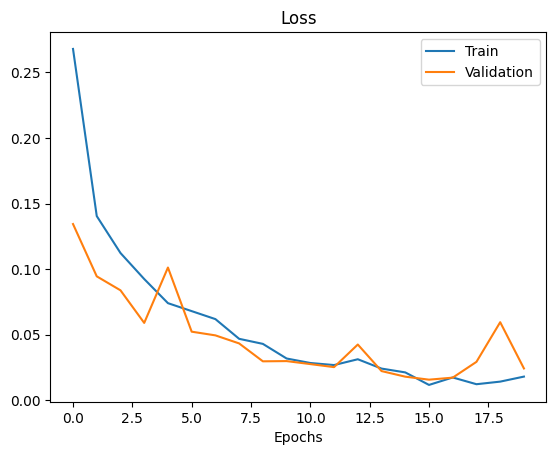

In [49]:
plt.plot(results.history['loss'], label='Train')
plt.plot(results.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

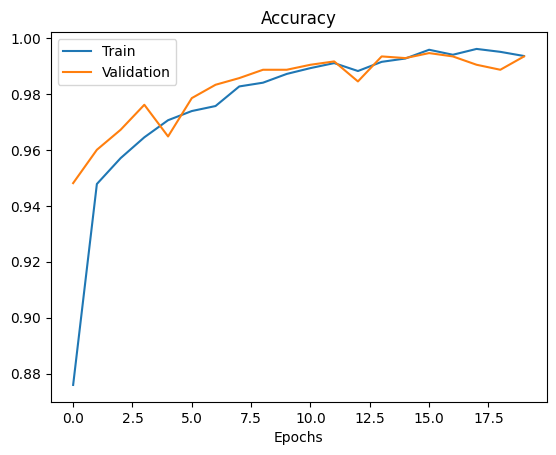

In [51]:
plt.plot(results.history['accuracy'], label='Train')
plt.plot(results.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()

In [53]:
model.save('models/model_frq5_inputs16.h5')
dump(scaler, 'models/scaler.bin')

['models/scaler.bin']